In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
os.chdir('../../')

In [3]:
from musicautobot.numpy_encode import *
from musicautobot.config import *
from musicautobot.music_transformer import *
from musicautobot.multitask_transformer import *
from musicautobot.utils import midifile

# Encoding Midi Files to Tensor

Step by step on transforming a MIDI file into a tensor.
This notebook is more of an FYI, as the details are not necessary for training

#### For a more high level API, see `MusicItem`

MusicItem wraps all these functions in a simplified API. See this [notebook](MusicItem-Transform.ipynb) for more details

## Overview

Start with something that looks like this:

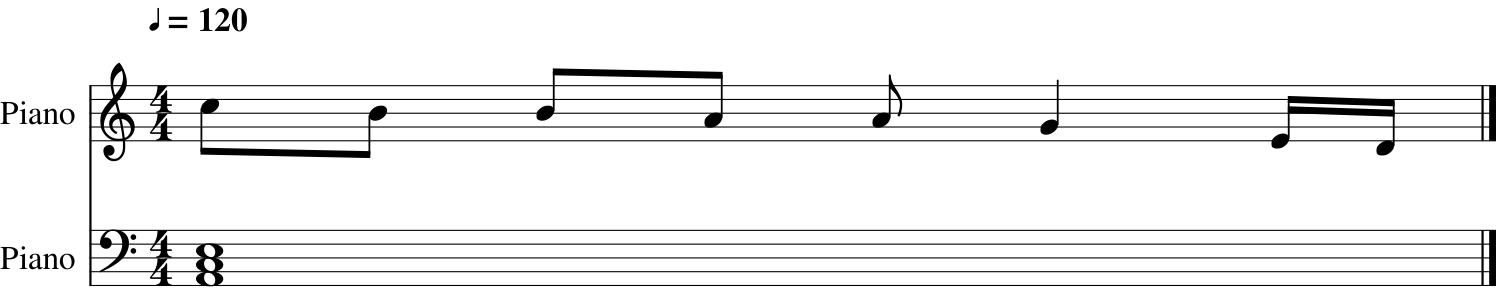

In [4]:
midi_file = Path('data/midi/notebook_examples/single_bar_example.mid')
vocab = MusicVocab.create()
item = MusicItem.from_file(midi_file, vocab); item.show()

And end up with a Tensor that looks like this:

In [5]:
item.to_tensor()

tensor([  0,   1,  81, 139,  61, 153,  57, 153,  54, 153,   8, 139,  80, 139,
          8, 139,  80, 139,   8, 139,  78, 139,   8, 139,  78, 139,   8, 139,
         76, 141,   8, 141,  73, 138,   8, 138,  71, 138], device='cuda:0')

## Basic Steps:

A basic step by step process to show how the library encodes a midi file like this:

1. MidiFile - Load a single midi file
2. Music21 Stream - Python Library helps with manipulating music files
3. Chord Encoding - Encode stream to a sparse matrix
4. Note Encoding - Intermediate dense matrix encoding
5. Tensor Encoding - Final single tensor for training

## 1. MidiFile

[MIDI](https://en.wikipedia.org/wiki/MIDI) is a standardized digital music representation that looks like this:

In [6]:
mf = midifile.file2mf(midi_file); mf

<MidiFile 2 tracks
  <MidiTrack 0 -- 44 events
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent SEQUENCE_TRACK_NAME, t=None, track=0, channel=None, data=b'Piano'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent PROGRAM_CHANGE, t=None, track=0, channel=1, data=0>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent PITCH_BEND, t=None, track=0, channel=1, parameter1=0, parameter2=64>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent PROGRAM_CHANGE, t=None, track=0, channel=1, data=0>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent SET_TEMPO, t=None, track=0, channel=None, data=b'\x07\xa1 '>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent NOTE_ON, t=None, track=0, channel=1, pitch=72, velocity=90>
    <MidiEvent DeltaTime, t=512, track=0, channel=None>
    <MidiEvent NOTE_OFF, t=None, track=0, channel=1, pitch=72, velocity=0>
    <MidiEvent DeltaTime, t=0, track=0, channel

## 2. Music21 Stream

[Music21](https://web.mit.edu/music21/) is powerful python library that helps us manipulate these MIDI files

In [7]:
stream = file2stream(mf)

In [8]:
stream.show('text')

{0.0} <music21.stream.Part 0x7fe65c1455f8>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark animato Quarter=120.0>
    {0.0} <music21.note.Note C>
    {0.5} <music21.note.Note B>
    {1.0} <music21.note.Note B>
    {1.5} <music21.note.Note A>
    {2.0} <music21.note.Note A>
    {2.5} <music21.note.Note G>
    {3.5} <music21.note.Note E>
    {3.75} <music21.note.Note D>
{0.0} <music21.stream.Part 0x7fe65c1452b0>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.chord.Chord A2 C3 E3>


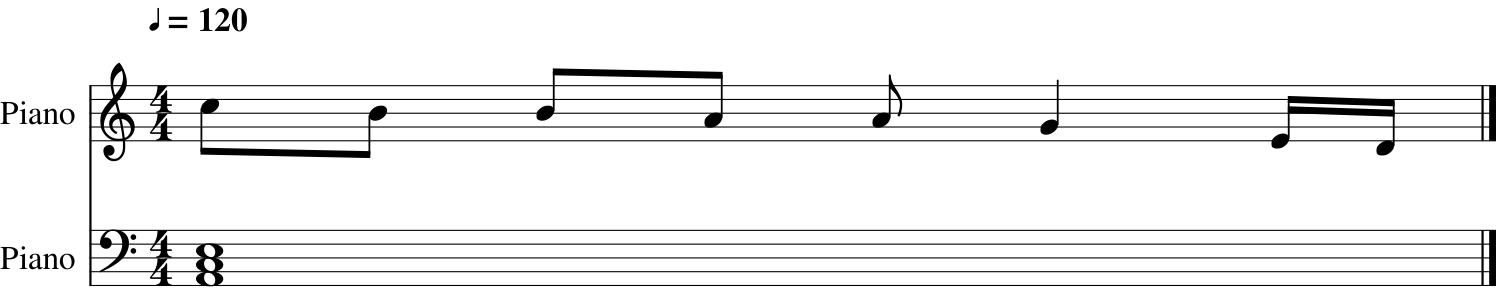

In [9]:
stream.show()

In [10]:
stream.show('midi')

## 3. Chord Encoding

Take the music21 stream object and encode it into a sparse numpy matrix. This matrix represents which notes are played at which timesteps

In [11]:
chordarr = stream2chordarr(stream); chordarr.shape

(17, 2, 128)

##### Chord Encoding Dimensions - (timestep x track x notes)


17 = timesteps in song  
2 = tracks/parts (track 1 = melody, track 2 = chords)  
128 = midi pitch range - [reference](https://www.inspiredacoustics.com/en/MIDI_note_numbers_and_center_frequencies)  

##### Representation

In [12]:
chordarr

array([[[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       ...,

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]])

In [13]:
# First timestep
ts1 = chordarr[0].nonzero(); ts1

(array([0, 1, 1, 1]), array([72, 45, 48, 52]))

First timestep, contains the midi notes 72, 45, 48, 52.  
Equivalent to (C5 A2 C3 E3)

In [16]:
c = music21.chord.Chord(ts1[1].tolist()); c

<music21.chord.Chord C5 A2 C3 E3>

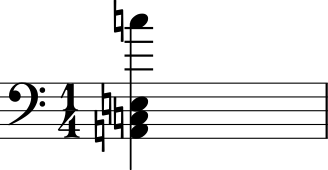

In [17]:
c.show()

## 4. Note Encoding

Convert chord encoding to a dense matrix representation.  

Sparse Matrix (177 x 2 x 128) takes up too much space.  
Instead of 0's and 1's. Let's only keep track of when and how long a note is played.

In [18]:
npenc = chordarr2npenc(chordarr); npenc.shape

(18, 2)

##### Encoding Dimensions: (timesteps, (pitch x duration))

18 = timesteps  
2 = note representation (pitch x duration)
* note pitch range (1-128)
  * Separator Index = -1
* note duration range (1 - 256)
  * Quarter Note = 4

#### Comparing matrix sizes:

In [19]:
f'Chord encoding size: {np.prod(chordarr.shape)}', f'Note encoding size: {np.prod(npenc.shape)}'

('Chord encoding size: 4352', 'Note encoding size: 36')

Much smaller

#### Representation

Single note:

In [20]:
n = npenc[0:1]; n

array([[72,  2]])

72 = C4 (note pitch)  
2 = Eighth Note (2 1/16th notes)

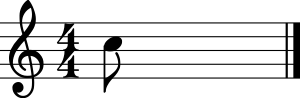

In [21]:
npenc2stream(n).show()

Chord:

In [22]:
c = npenc[1:4]; c

array([[52, 16],
       [48, 16],
       [45, 16]])

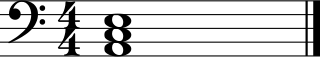

In [23]:
npenc2stream(c).show()

#### Full Representation

In [24]:
npenc[:8]

array([[72,  2],
       [52, 16],
       [48, 16],
       [45, 16],
       [-1,  2],
       [71,  2],
       [-1,  2],
       [71,  2]])

Note encoding represents a stream of notes followed by a `-1` index. 

`-1` is a special encoding that separates each group of notes to a different timestep.

The above basically says -
1. Play notes (72, 52, 48, 45) all at once
2. Wait (-1, 2) for 1/8th beat
3. Play (71, 2) - B4 Eighth Note
4. Wait (-1, 2) for 1/8th beat
5. Play (71, 2) - B4 Eighth Note

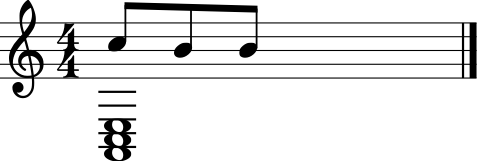

In [25]:
npenc2stream(npenc[:8]).show()

## Tensor Encoding

Vocab indexed tensor encoding for training

In [26]:
idxenc = npenc2idxenc(npenc, vocab); idxenc.shape

(38,)

Tensor encoding converts note encoding to a single dimensional array, required for training. 

Indexes are encoded according to the vocab dictionary -

In [27]:
list(vocab.stoi.items())[:15]

[('xxbos', 0),
 ('xxpad', 1),
 ('xxeos', 2),
 ('xxs2scls', 3),
 ('xxmask', 4),
 ('xxcseq', 5),
 ('xxmseq', 6),
 ('xxnscls', 7),
 ('xxsep', 8),
 ('n0', 9),
 ('n1', 10),
 ('n2', 11),
 ('n3', 12),
 ('n4', 13),
 ('n5', 14)]

#### Representation

In [28]:
idxenc

array([  0,   1,  81, 139,  61, 153,  57, 153,  54, 153,   8, 139,  80, 139,   8, 139,  80, 139,   8, 139,  78, 139,
         8, 139,  78, 139,   8, 139,  76, 141,   8, 141,  73, 138,   8, 138,  71, 138])

More human readable:

In [29]:
vocab.textify(idxenc)

'xxbos xxpad n72 d2 n52 d16 n48 d16 n45 d16 xxsep d2 n71 d2 xxsep d2 n71 d2 xxsep d2 n69 d2 xxsep d2 n69 d2 xxsep d2 n67 d4 xxsep d4 n64 d1 xxsep d1 n62 d1'

'xxbos xxpad' is inserted at the beginning of each sequence so the model can distinguish when multiple music files are combined